In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
# Read the data
df = pd.read_csv('hi1_20170701_20200609.csv')

# Check column names
print("Column names:", df.columns.tolist())
print("First few rows:")
print(df.head())

# Assuming the first column is date and second is time, but they might have different names
date_col = df.columns[0]
time_col = df.columns[1]
print(f"Using '{date_col}' as date column and '{time_col}' as time column")

# Convert date and time to proper format
df[date_col] = df[date_col].astype(str)
df[time_col] = df[time_col].astype(str).str.zfill(6)

# Convert price and volume columns to numeric
price_cols = [col for col in df.columns[2:]]
for col in price_cols:
    df[col] = pd.to_numeric(df[col])

# Initialize variables for tracking
daily_profits = []
total_profit = 0
max_daily_loss = -200  # Stop trading if flat position loss exceeds this value
unique_dates = df[date_col].unique()

# Process each trading day
for date in unique_dates:

    day_data = df[df[date_col] == date].reset_index(drop=True)
    
    if len(day_data) < 52:  # Skip days with insufficient data
        print(f"Date {date}: Insufficient data points, skipping")
        daily_profits.append(0)
        continue
    
    # Initialize daily variables
    position = 0  # 0 = flat, positive = long, negative = short
    day_profit = 0
    
    # Determine the last 60 minutes index
    last_60_min_index = max(0, len(day_data) - 60)
    
    # Start trading from the 52nd minute
    for i in range(51, len(day_data)):
        # Check if daily loss limit exceeded (when in flat position)
        if position == 0 and day_profit < max_daily_loss:
            print(f"Date {date}: Daily loss of {day_profit:.2f} exceeds limit of {max_daily_loss}. Stopping trading for today.")
            break
            
        current_price = day_data.iloc[i, df.columns.get_loc('hi1_close')]
        
        # Check if this is the last minute of the day
        is_last_minute = (i == len(day_data) - 1)
        
        # Check if we're in the last 60 minutes
        is_last_60_min = (i >= last_60_min_index)
        
        # If not the last minute, make prediction using ARIMA(1,1,1)
        if not is_last_minute:
            # Get the last 50 closing prices
            history = day_data.iloc[i-50:i+1, df.columns.get_loc('hi1_close')].values
            
            try:
                # Fit ARIMA model
                model = ARIMA(history, order=(1, 1, 1))
                model_fit = model.fit()
                
                # Make one-step forecast
                forecast = model_fit.forecast(steps=1)[0]
                predicted_change = forecast - current_price
            except:
                # If ARIMA fails, assume no change
                predicted_change = 0
        
        # Force liquidation at the end of the day
        if is_last_minute and position != 0:
            if position > 0:  # Long position
                # Sell all contracts
                day_profit += position * (current_price - 2)
                print(f"Date {date}, Time {day_data.iloc[i][time_col]}: End of day - Liquidating {position} long contracts at {current_price}")
                position = 0
            else:  # Short position
                # Buy back all contracts
                day_profit -= abs(position) * (current_price + 2)
                print(f"Date {date}, Time {day_data.iloc[i][time_col]}: End of day - Liquidating {abs(position)} short contracts at {current_price}")
                position = 0
        
        # Execute trading strategy if not the last minute
        elif not is_last_minute:
            # In the last 60 minutes, only allow closing positions, not opening new ones
            if is_last_60_min:
                if position > 0 and predicted_change < -2:  # Long position and prediction to decrease
                    day_profit += position * (current_price - 2)
                    print(f"Date {date}, Time {day_data.iloc[i][time_col]}: Last 60 min - Closing {position} long contracts at {current_price}")
                    position = 0
                elif position < 0 and predicted_change > 2:  # Short position and prediction to increase
                    day_profit -= abs(position) * (current_price + 2)
                    print(f"Date {date}, Time {day_data.iloc[i][time_col]}: Last 60 min - Closing {abs(position)} short contracts at {current_price}")
                    position = 0
            else:
                # Normal trading logic for non-last 60 minutes
                margin_requirement = abs(position + 1) * current_price * 0.1  # 10% margin
                
                # Case 1: Currently flat
                if position == 0:
                    if predicted_change > 2:  # Buy signal
                        if margin_requirement <= 15000:
                            position = 1
                            day_profit -= (current_price + 2)  # Buy price + commission
                            #print(f"Date {date}, Time {day_data.iloc[i][time_col]}: Buy 1 contract at {current_price}, predicted change: {predicted_change:.2f}")
                    elif predicted_change < -2:  # Sell signal
                        if margin_requirement <= 15000:
                            position = -1
                            day_profit += (current_price - 2)  # Sell price - commission
                            #print(f"Date {date}, Time {day_data.iloc[i][time_col]}: Sell 1 contract at {current_price}, predicted change: {predicted_change:.2f}")
                
                # Case 2: Currently long
                elif position > 0:
                    if predicted_change > 2:  # Buy more
                        margin_requirement = (position + 1) * current_price * 0.1
                        if margin_requirement <= 15000:
                            position += 1
                            day_profit -= (current_price + 2)
                            #print(f"Date {date}, Time {day_data.iloc[i][time_col]}: Buy 1 more contract at {current_price}, predicted change: {predicted_change:.2f}")
                    elif predicted_change < -2:  # Liquidate all
                        day_profit += position * (current_price - 2)
                        #print(f"Date {date}, Time {day_data.iloc[i][time_col]}: Sell {position} contracts at {current_price}, predicted change: {predicted_change:.2f}")
                        position = 0
                
                # Case 3: Currently short
                else:  # position < 0
                    if predicted_change < -2:  # Sell more
                        margin_requirement = (abs(position) + 1) * current_price * 0.1
                        if margin_requirement <= 15000:
                            position -= 1
                            day_profit += (current_price - 2)
                            #print(f"Date {date}, Time {day_data.iloc[i][time_col]}: Sell 1 more contract at {current_price}, predicted change: {predicted_change:.2f}")
                    elif predicted_change > 2:  # Liquidate all
                        day_profit -= abs(position) * (current_price + 2)
                        #print(f"Date {date}, Time {day_data.iloc[i][time_col]}: Buy back {abs(position)} contracts at {current_price}, predicted change: {predicted_change:.2f}")
                        position = 0
    
    # Record daily profit
    daily_profits.append(day_profit)
    total_profit += day_profit
    print(f"Date {date}: Daily P&L = {day_profit:.2f} HSI points")

Column names: ['date', 'time', 'hi1_open', 'hi1_high', 'hi1_low', 'hi1_close', 'hi1_volume']
First few rows:
       date   time  hi1_open  hi1_high  hi1_low  hi1_close  hi1_volume
0  20170703  91400   25524.0   25524.0  25524.0    25524.0       639.0
1  20170703  91500   25530.0   25557.0  25506.0    25547.0       941.0
2  20170703  91600   25549.0   25564.0  25547.0    25560.0       371.0
3  20170703  91700   25558.0   25568.0  25549.0    25568.0       383.0
4  20170703  91800   25568.0   25574.0  25558.0    25562.0       288.0
Using 'date' as date column and 'time' as time column
Date 20170703, Time 234400: End of day - Liquidating 1 long contracts at 25764.0
Date 20170703: Daily P&L = 372.00 HSI points
Date 20170704: Daily loss of -328.00 exceeds limit of -200. Stopping trading for today.
Date 20170704: Daily P&L = -328.00 HSI points
Date 20170705: Daily loss of -213.00 exceeds limit of -200. Stopping trading for today.
Date 20170705: Daily P&L = -213.00 HSI points
Date 20170706, Ti


Trading Results Summary:
Total P&L: 6000.00 HSI points (HKD 300000.00)
Number of trading days: 63
Average daily P&L: 95.24 HSI points
Best day: 10019.00 HSI points
Worst day: -494.00 HSI points


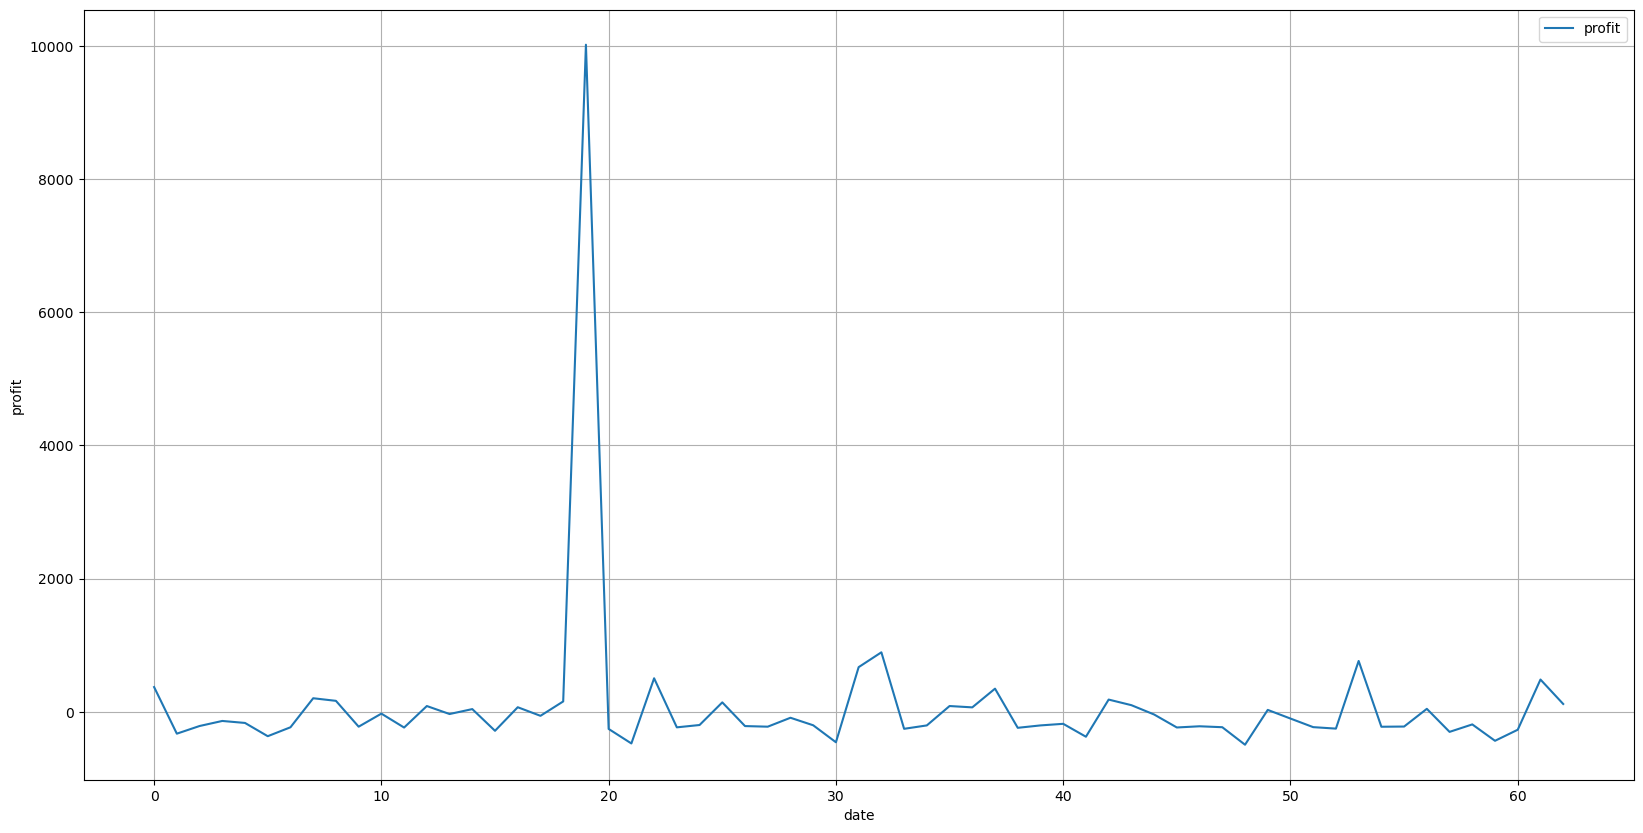

In [3]:
# Calculate final results
print("\nTrading Results Summary:")
print(f"Total P&L: {total_profit:.2f} HSI points (HKD {total_profit * 50:.2f})")
print(f"Number of trading days: {len(daily_profits)}")
print(f"Average daily P&L: {np.mean(daily_profits):.2f} HSI points")
print(f"Best day: {np.max(daily_profits):.2f} HSI points")
print(f"Worst day: {np.min(daily_profits):.2f} HSI points")

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(daily_profits, label='profit')
plt.xlabel('date')
plt.ylabel('profit')
plt.legend()
plt.grid(True)

plt.savefig('profit111200.png', dpi=300)
plt.show()